# Exploratory data analysis for meetup attendees data

The notebook serves the purpose of gathering insights from Operate first data science meetup attendees data by doing an exploratory data analysis.

In [2]:
import os
import pandas as pd
import boto3
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
from dotenv import find_dotenv, load_dotenv
load_dotenv(find_dotenv())

True

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
warnings.filterwarnings("ignore")

## Accessing the environment keys:

In [4]:
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")

We will be using boto3 client and resource, s3_client and s3_resource, in order to explore the contents of the bucket.

In [5]:
s3_client = boto3.client('s3', endpoint_url= s3_endpoint_url,
                       aws_access_key_id = s3_access_key,
                       aws_secret_access_key = s3_secret_key)
s3_resource = boto3.resource('s3', endpoint_url= s3_endpoint_url,
                       aws_access_key_id = s3_access_key,
                       aws_secret_access_key = s3_secret_key)

The meetup attendees data are stored in `opf-datacatlog` bucket in this folder: `open-services-group/operate-first-data-science-community/meetup_attendees`. In order to extract them, we can follow the steps as shown below:

In [6]:
my_bucket = s3_resource.Bucket(s3_bucket)

for object_file in my_bucket.objects.filter(Prefix="open-services-group/operate-first-data-science-community/meetup_attendees/"):
    print(object_file.key)

open-services-group/operate-first-data-science-community/meetup_attendees/obfuscated_2021-12-14_10_58_EYBYEGJGJI_Attendance_Report-Attendees.csv
open-services-group/operate-first-data-science-community/meetup_attendees/obfuscated_2022-01-25_10_52_EYBYEGJGJI_Attendance_Report-Attendees.csv
open-services-group/operate-first-data-science-community/meetup_attendees/obfuscated_2022-02-08_10_50_EYBYEGJGJI_Attendance_Report-Attendees.csv
open-services-group/operate-first-data-science-community/meetup_attendees/obfuscated_2022-02-22_10_49_EYBYEGJGJI_Attendance_Report-Attendees.csv
open-services-group/operate-first-data-science-community/meetup_attendees/obfuscated_2022-03-08_10_58_EYBYEGJGJI_Attendance_Report-Attendees.csv
open-services-group/operate-first-data-science-community/meetup_attendees/obfuscated_2022-03-22_10_51_EYBYEGJGJI_Attendance_Report-Attendees.csv


Next, we will extract these dataframe and merge them by row so that it is easier to do EDA on it.

In [7]:
merged_df = pd.DataFrame([])
for object_file in my_bucket.objects.filter(Prefix="open-services-group/operate-first-data-science-community/meetup_attendees/"):
    obj = s3_client.get_object(Bucket=s3_bucket, Key = object_file.key)
    df = pd.read_csv(obj['Body'])
    df.drop(['Unnamed: 0'], 1, inplace=True)
    merged_df = merged_df.append(df, ignore_index=True)    

In [8]:
merged_df.shape

(155, 6)

In [9]:
merged_df.head()

,Date,Name#,Email,Duration,Time_joined,Time_exited
0,2021-12-14,513fa0b6615335d0bed0a1dcdb40e1e515c07619608650...,redhat.com,30 min,11:02 AM,11:32 AM
1,2021-12-14,c0600eaa67ce4b171cb130cfa4914cc54d163384012e93...,redhat.com,30 min,11:02 AM,11:32 AM
2,2021-12-14,864042274f41a29a5b7fb860c7ec9fb3c1e6ec0e994731...,redhat.com,30 min,11:02 AM,11:32 AM
3,2021-12-14,c281759f750aa8f477d025643494df52e531935a0bfbb1...,redhat.com,31 min,11:02 AM,11:33 AM
4,2021-12-14,76ecf41e4da0c8629abadab0ea6751c7a85f0fe632a96d...,redhat.com,30 min,11:02 AM,11:32 AM


So in our data we have Date of meetup, hashed name of attendees, respective domain name of emails, and information about the duration, joined time and exit time from the meetup. 

In [10]:
print(f'The different meetup dates are {merged_df.Date.unique()}')

The different meetup dates are ['2021-12-14' '2022-01-25' '2022-02-08' '2022-02-22' '2022-03-08'
 '2022-03-22']


In order to check what types of variables are in the date, we do,

In [11]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         155 non-null    object
 1   Name#        155 non-null    object
 2   Email        154 non-null    object
 3   Duration     155 non-null    object
 4   Time_joined  155 non-null    object
 5   Time_exited  155 non-null    object
dtypes: object(6)
memory usage: 7.4+ KB


We see that all the columns are type object. In the next step, we will change the type of respective variables, so that it is easier for later analysis. 

In [12]:
merged_df['Time_joined'] = pd.to_datetime(merged_df['Date'] + " " + merged_df['Time_joined'])
merged_df['Time_exited'] = pd.to_datetime(merged_df['Date'] + " " + merged_df['Time_exited'])
merged_df['Duration'] = merged_df['Duration'].map(lambda x : x.rstrip('minsec'))
merged_df['Duration'] = merged_df['Duration'].astype(float)
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

In [13]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         155 non-null    datetime64[ns]
 1   Name#        155 non-null    object        
 2   Email        154 non-null    object        
 3   Duration     155 non-null    float64       
 4   Time_joined  155 non-null    datetime64[ns]
 5   Time_exited  155 non-null    datetime64[ns]
dtypes: datetime64[ns](3), float64(1), object(2)
memory usage: 7.4+ KB


In [14]:
merged_df.head()

,Date,Name#,Email,Duration,Time_joined,Time_exited
0,2021-12-14,513fa0b6615335d0bed0a1dcdb40e1e515c07619608650...,redhat.com,30.0,2021-12-14 11:02:00,2021-12-14 11:32:00
1,2021-12-14,c0600eaa67ce4b171cb130cfa4914cc54d163384012e93...,redhat.com,30.0,2021-12-14 11:02:00,2021-12-14 11:32:00
2,2021-12-14,864042274f41a29a5b7fb860c7ec9fb3c1e6ec0e994731...,redhat.com,30.0,2021-12-14 11:02:00,2021-12-14 11:32:00
3,2021-12-14,c281759f750aa8f477d025643494df52e531935a0bfbb1...,redhat.com,31.0,2021-12-14 11:02:00,2021-12-14 11:33:00
4,2021-12-14,76ecf41e4da0c8629abadab0ea6751c7a85f0fe632a96d...,redhat.com,30.0,2021-12-14 11:02:00,2021-12-14 11:32:00


We converted the date and time objects into respective datetime variables. 

In [16]:
merged_df.Duration.describe()

count    155.000000
mean      28.877419
std       12.118107
min        0.000000
25%       21.000000
50%       30.000000
75%       38.000000
max       52.000000
Name: Duration, dtype: float64

### Number of attendees by dates:

In [17]:
print(f'Total number of unique attendees is {merged_df["Name#"].nunique()}. '
       'Out of those, lets see how many attendees have attended each meetup.')

Total number of unique attendees is 74. Out of those, lets see how many attendees have attended each meetup.


In [18]:
merged_df.groupby(merged_df['Date'].dt.date)['Name#'].count()

Date
2021-12-14    23
2022-01-25    30
2022-02-08    32
2022-02-22    27
2022-03-08    23
2022-03-22    20
Name: Name#, dtype: int64

<AxesSubplot:xlabel='Date'>

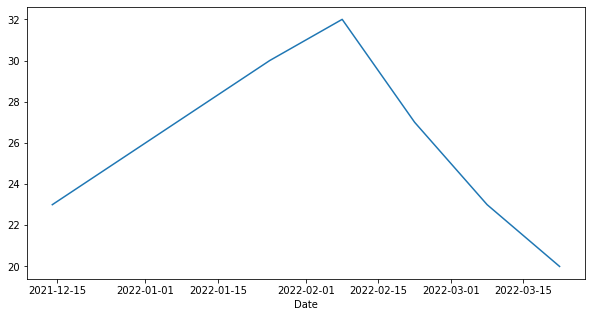

In [19]:
plt.figure(figsize=(10,5))
merged_df.groupby(merged_df['Date'].dt.date)['Name#'].count().plot()

### Average duration by dates:

In [20]:
merged_df.groupby(merged_df['Date'].dt.date)['Duration'].mean()

Date
2021-12-14    28.608696
2022-01-25    21.066667
2022-02-08    32.531250
2022-02-22    37.777778
2022-03-08    32.782609
2022-03-22    18.550000
Name: Duration, dtype: float64

<AxesSubplot:xlabel='Date'>

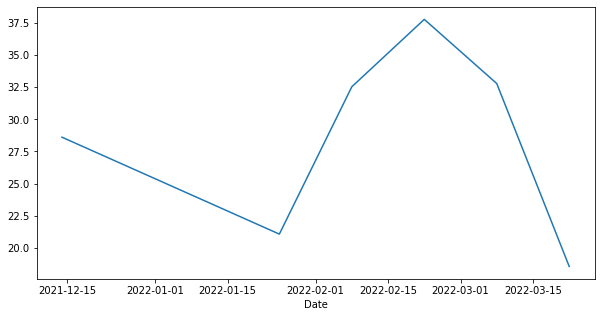

In [21]:
plt.figure(figsize=(10,5))
merged_df.groupby(merged_df['Date'].dt.date)['Duration'].mean().plot()

### Attendees for different dates

We apply groupby method in order to segregate the number of attendees based on different dates.

In [66]:
df = merged_df.groupby('Name#')['Date'].nunique().to_frame().sort_values('Date', ascending=False)
df.rename(columns={'Date':"Frequency"}, inplace=True)

The given dataframe gives us the sorted list of attendees attending the meetup. 

In [70]:
df.head(10)

,Name#,Frequency
0,0e3a7339abb84525e1a770694b91cb1a4fe904359aef4d...,6
1,c0600eaa67ce4b171cb130cfa4914cc54d163384012e93...,6
2,c3f58c6e9bb7bd16672310707d5dc4c803572f72326390...,5
3,851d03c038734db871185f076d5b0bea813bcde8fd839a...,5
4,513fa0b6615335d0bed0a1dcdb40e1e515c07619608650...,5
5,cab3ba0fb82d66051a855f635407457757d281d4693e20...,5
6,b4ce2f8e9d439cc2878d757320a7daf475632b88c5a665...,5
7,76ecf41e4da0c8629abadab0ea6751c7a85f0fe632a96d...,5
8,864042274f41a29a5b7fb860c7ec9fb3c1e6ec0e994731...,5
9,c281759f750aa8f477d025643494df52e531935a0bfbb1...,5


Now, lets apply the groupby method again in order to get the number of attendees attending meetup sessions.

In [74]:
df = df.reset_index()
df1 = df.groupby('Frequency')['Name#'].nunique().to_frame().sort_values('Name#', ascending=False).reset_index()
df1.rename(columns={'Name#':'Number_of_attendees'}, inplace=True)

In [75]:
df1

,Frequency,Number_of_attendees
0,1,43
1,2,11
2,5,8
3,4,7
4,3,3
5,6,2


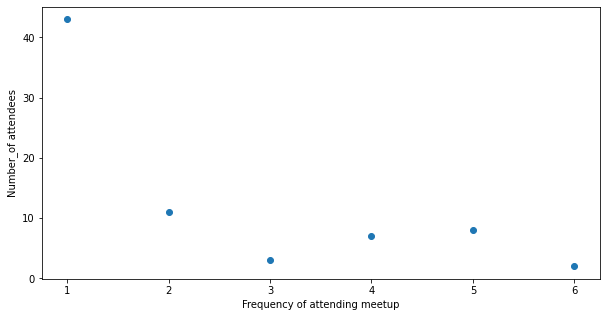

In [82]:
plt.figure(figsize=(10,5))
plt.scatter(df1.Frequency, df1.Number_of_attendees)
plt.ylabel('Number_of attendees')
plt.xlabel("Frequency of attending meetup")
plt.show()

# Conclusion 

In this notebook, we did the EDA for meetup attendees data and gather some insights such as number of unique attendees, repetative attendees, duration of meetup, etc. We hope this be helpful in order to build participation in community building. 